<h2>
    <b><span style="color:crimson;">Author : </span></b>Alireza, Casey D, Jay B <br><br>
    <b><span style="color:crimson;">Project Title : </span></b>TIC-TAC-TOE using Q-Learning and Sarsa-Learning 
    </span>
</b></h2>
<h4>Created on Thu Dec 16 17:13:35 2021</h4>

<h3><b>Libraries used

In [2]:
from abc import ABC, abstractmethod
import os
import pickle
import collections
import numpy as np
import random
import argparse
import sys
import matplotlib.pylab as plt

<h3><b>Common methods for Q-Learning & Sarsa Learning , "Parent Class"

In [3]:
class parentQS(ABC):
    
    def __init__(self, alpha, gamma, eps, eps_decay=0.):
        # Agent parameters
        self.alpha = alpha #learning rate
        self.gamma = gamma #temporal discounting rate
        self.eps = eps #probability of random action vs. greedy action
        self.eps_decay = eps_decay #epsilon decay rate. Larger value = more decay
        self.actions = [] # Possible actions correspond to the set of all x,y coordinate pairs
        
        for i in range(3):
            for j in range(3):
                self.actions.append((i,j))       
        self.Q = {}
        for action in self.actions:
            self.Q[action] = collections.defaultdict(int)
        self.rewards = []

    def getAction(self, s):
        possibleMove = [a for a in self.actions if s[a[0]*3 + a[1]] == '-']
        if random.random() < self.eps:
            action = possibleMove[random.randint(0,len(possibleMove)-1)]
        else:
            values = np.array([self.Q[a][s] for a in possibleMove])
            ix_max = np.where(values == np.max(values))[0]
            if len(ix_max) > 1:
                ix_select = np.random.choice(ix_max, 1)[0]
            else:
                ix_select = ix_max[0]
            action = possibleMove[ix_select]
        self.eps *= (1.-self.eps_decay)
        return action

    def saveState(self, path):
        if os.path.isfile(path):
            os.remove(path)
        f = open(path, 'wb')
        pickle.dump(self, f)
        f.close()

    @abstractmethod
    def update(self, s, s_, a, a_, r):
        pass

<h3><b>Q-Learning Implementation for Tic-Tac-Toe Game Board

<img src="https://miro.medium.com/max/700/1*7AWfjw8YDfoRqnIO71DjiA.png">

In [4]:
class qLearning(parentQS):
    def __init__(self, alpha, gamma, eps, eps_decay=0.):
        super().__init__(alpha, gamma, eps, eps_decay)

    def update(self, s, s_, a, a_, r):
        if s_ is not None:
            possibleMove = [action for action in self.actions if s_[action[0]*3 + action[1]] == '-']
            Q_options = [self.Q[action][s_] for action in possibleMove]
            self.Q[a][s] += self.alpha*(r + self.gamma*max(Q_options) - self.Q[a][s])
        else:
            self.Q[a][s] += self.alpha*(r - self.Q[a][s])
        self.rewards.append(r)

<h3><b>SARSA Learning Implementation for Tic-Tac-Toe Game Board

<img src = "https://miro.medium.com/max/2400/1*7WZZgbJQr5lh86LRB2pbVg.png">

In [5]:
class sarsaLearning(parentQS):
    def __init__(self, alpha, gamma, eps, eps_decay=0.):
        super().__init__(alpha, gamma, eps, eps_decay)

    def update(self, s, s_, a, a_, r):
        if s_ is not None:
            self.Q[a][s] += self.alpha*(r + self.gamma*self.Q[a_][s_] - self.Q[a][s])
        else:
            self.Q[a][s] += self.alpha*(r - self.Q[a][s])
        self.rewards.append(r)

In [6]:
class trainerForQS:
   
    def __init__(self, level=0.9):
        self.ability_level = level

    def win(self, board, key='X'):
        a = [board[0][0], board[1][1], board[2][2]]
        b = [board[0][2], board[1][1], board[2][0]]
        if a.count('-') == 1 and a.count(key) == 2:
            ind = a.index('-')
            return ind, ind
        elif b.count('-') == 1 and b.count(key) == 2:
            ind = b.index('-')
            if ind == 0:
                return 0, 2
            elif ind == 1:
                return 1, 1
            else:
                return 2, 0
        for i in range(3):
            c = [board[0][i], board[1][i], board[2][i]]
            d = [board[i][0], board[i][1], board[i][2]]
            if c.count('-') == 1 and c.count(key) == 2:
                ind = c.index('-')
                return ind, i
            elif d.count('-') == 1 and d.count(key) == 2:
                ind = d.index('-')
                return i, ind
        return None

    def blockWin(self, board):
        return self.win(board, key='O')

    def fork(self, board):
        if board[1][0] == 'X' and board[0][1] == 'X':
            if board[0][0] == '-' and board[2][0] == '-' and board[0][2] == '-':
                return 0, 0
            elif board[1][1] == '-' and board[2][1] == '-' and board[1][2] == '-':
                return 1, 1
        elif board[1][0] == 'X' and board[2][1] == 'X':
            if board[2][0] == '-' and board[0][0] == '-' and board[2][2] == '-':
                return 2, 0
            elif board[1][1] == '-' and board[0][1] == '-' and board[1][2] == '-':
                return 1, 1
        elif board[2][1] == 'X' and board[1][2] == 'X':
            if board[2][2] == '-' and board[2][0] == '-' and board[0][2] == '-':
                return 2, 2
            elif board[1][1] == '-' and board[1][0] == '-' and board[0][1] == '-':
                return 1, 1
        elif board[1][2] == 'X' and board[0][1] == 'X':
            if board[0][2] == '-' and board[0][0] == '-' and board[2][2] == '-':
                return 0, 2
            elif board[1][1] == '-' and board[1][0] == '-' and board[2][1] == '-':
                return 1, 1
        elif board[0][0] == 'X' and board[2][2] == 'X':
            if board[1][0] == '-' and board[2][1] == '-' and board[2][0] == '-':
                return 2, 0
            elif board[0][1] == '-' and board[1][2] == '-' and board[0][2] == '-':
                return 0, 2
        elif board[2][0] == 'X' and board[0][2] == 'X':
            if board[2][1] == '-' and board[1][2] == '-' and board[2][2] == '-':
                return 2, 2
            elif board[1][0] == '-' and board[0][1] == '-' and board[0][0] == '-':
                return 0, 0
        return None

    def blockFork(self, board):
        corners = [board[0][0], board[2][0], board[0][2], board[2][2]]
        if board[1][0] == 'O' and board[0][1] == 'O':
            if board[0][0] == '-' and board[2][0] == '-' and board[0][2] == '-':
                return 0, 0
            elif board[1][1] == '-' and board[2][1] == '-' and board[1][2] == '-':
                return 1, 1
        elif board[1][0] == 'O' and board[2][1] == 'O':
            if board[2][0] == '-' and board[0][0] == '-' and board[2][2] == '-':
                return 2, 0
            elif board[1][1] == '-' and board[0][1] == '-' and board[1][2] == '-':
                return 1, 1
        elif board[2][1] == 'O' and board[1][2] == 'O':
            if board[2][2] == '-' and board[2][0] == '-' and board[0][2] == '-':
                return 2, 2
            elif board[1][1] == '-' and board[1][0] == '-' and board[0][1] == '-':
                return 1, 1
        elif board[1][2] == 'O' and board[0][1] == 'O':
            if board[0][2] == '-' and board[0][0] == '-' and board[2][2] == '-':
                return 0, 2
            elif board[1][1] == '-' and board[1][0] == '-' and board[2][1] == '-':
                return 1, 1
        elif corners.count('-') == 1 and corners.count('O') == 2:
            return 1, 2
        elif board[0][0] == 'O' and board[2][2] == 'O':
            if board[1][0] == '-' and board[2][1] == '-' and board[2][0] == '-':
                return 2, 0
            elif board[0][1] == '-' and board[1][2] == '-' and board[0][2] == '-':
                return 0, 2
        elif board[2][0] == 'O' and board[0][2] == 'O':
            if board[2][1] == '-' and board[1][2] == '-' and board[2][2] == '-':
                return 2, 2
            elif board[1][0] == '-' and board[0][1] == '-' and board[0][0] == '-':
                return 0, 0
        return None

    def center(self, board):
        if board[1][1] == '-':
            return 1, 1
        return None

    def corner(self, board):
        if board[0][0] == 'O' and board[2][2] == '-':
            return 2, 2
        elif board[2][0] == 'O' and board[0][2] == '-':
            return 0, 2
        elif board[0][2] == 'O' and board[2][0] == '-':
            return 2, 0
        elif board[2][2] == 'O' and board[0][0] == '-':
            return 0, 0
        elif board[0][0] == '-':
            return 0, 0
        elif board[2][0] == '-':
            return 2, 0
        elif board[0][2] == '-':
            return 0, 2
        elif board[2][2] == '-':
            return 2, 2
        return None

    def sideEmpty(self, board):
        if board[1][0] == '-':
            return 1, 0
        elif board[2][1] == '-':
            return 2, 1
        elif board[1][2] == '-':
            return 1, 2
        elif board[0][1] == '-':
            return 0, 1
        return None

    def randomMove(self, board):
        possibles = []
        for i in range(3):
            for j in range(3):
                if board[i][j] == '-':
                    possibles += [(i, j)]
        return possibles[random.randint(0, len(possibles)-1)]

    def makeMove(self, board):
        if random.random() > self.ability_level:
            return self.randomMove(board)
        a = self.win(board)
        if a is not None:
            return a
        a = self.blockWin(board)
        if a is not None:
            return a
        a = self.fork(board)
        if a is not None:
            return a
        a = self.blockFork(board)
        if a is not None:
            return a
        a = self.center(board)
        if a is not None:
            return a
        a = self.corner(board)
        if a is not None:
            return a
        a = self.sideEmpty(board)
        if a is not None:
            return a
        return self.randomMove(board)

<h3><b>A class to holds the state of the learning process

In [7]:
class stateHolder(object):
    def __init__(self , path , agent_type, load = False , alpha=0.5, gamma=0.9, epsilon=0.1):

        if load:
            if not os.path.isfile(path):
                raise ValueError("Cannot load agent: file does not exist.")
            with open(path, 'rb') as f:
                agent = pickle.load(f)
        else:
            if os.path.isfile(path):
                print('An agent is already saved at {}.'.format(path))
                while True:
                    response = input("Are you sure you want to overwrite? [y/n]: ")
                    if response.lower() in ['y', 'yes']:
                        break
                    elif response.lower() in ['n', 'no']:
                        print("OK. Quitting.")
                        sys.exit(0)
                    else:
                        print("Invalid input. Please choose 'y' or 'n'.")
            if agent_type == "q":
                agent = qLearning(alpha,gamma,epsilon)
            else:
                agent = sarsaLearning(alpha,gamma,epsilon)

        self.games_played = 0
        self.path = path
        self.agent = agent

    def beginTeaching(self, episodes):
        trainer = trainerForQS()
        while self.games_played < episodes:
            game = Game(self.agent, trainer=trainer)
            game.start()
            self.games_played += 1
            if self.games_played % 1000 == 0:
                print("Games played: %i" % self.games_played)
        self.agent.saveState(self.path)

<h3><b>Game class : To process each new Game Play

In [8]:
class Game:
    def __init__(self, agent, trainer=None):
        self.agent = agent
        self.trainer = trainer
        self.board = [['-', '-', '-'], ['-', '-', '-'], ['-', '-', '-']]

    def playerMove(self):
        if self.trainer is not None:
            action = self.trainer.makeMove(self.board)
            self.board[action[0]][action[1]] = 'X'
        else:
            printBoard(self.board)
            while True:
                move = input("Your move! Please select a row and column from 0-2 "
                             "in the format row,col: ")
                print('\n')
                try:
                    row, col = int(move[0]), int(move[2])
                except ValueError:
                    print("INVALID INPUT! Please use the correct format.")
                    continue
                if row not in range(3) or col not in range(3) or not self.board[row][col] == '-':
                    print("INVALID MOVE! Choose again.")
                    continue
                self.board[row][col] = 'X'
                break

    def agentMove(self, action):
        self.board[action[0]][action[1]] = 'O'

    def checkForWin(self, key):
        a = [self.board[0][0], self.board[1][1], self.board[2][2]]
        b = [self.board[0][2], self.board[1][1], self.board[2][0]]
        if a.count(key) == 3 or b.count(key) == 3:
            return True
        for i in range(3):
            col = [self.board[0][i], self.board[1][i], self.board[2][i]]
            row = [self.board[i][0], self.board[i][1], self.board[i][2]]
            if col.count(key) == 3 or row.count(key) == 3:
                return True
        return False

    def checkForDraw(self):
        draw = True
        for row in self.board:
            for elt in row:
                if elt == '-':
                    draw = False
        return draw

    def checkForEnd(self, key):
        if self.checkForWin(key):
            if self.trainer is None:
                printBoard(self.board)
                if key == 'X':
                    print("Player wins!")
                else:
                    print("RL agent wins!")
            return 1
        elif self.checkForDraw():
            if self.trainer is None:
                printBoard(self.board)
                print("It's a draw!")
            return 0
        return -1

    def playGame(self, player_first):
        if player_first:
            self.playerMove()
        prev_state = getStateKey(self.board)
        prev_action = self.agent.getAction(prev_state)

        while True:
            self.agentMove(prev_action)
            check = self.checkForEnd('O')
            if not check == -1:
                reward = check
                break
            self.playerMove()
            check = self.checkForEnd('X')
            if not check == -1:
                reward = -1*check
                break
            else:
                reward = 0
            new_state = getStateKey(self.board)
            new_action = self.agent.getAction(new_state)
            self.agent.update(prev_state, new_state, prev_action, new_action, reward)
            prev_state = new_state
            prev_action = new_action

        self.agent.update(prev_state, None, prev_action, None, reward)

    def start(self):
        if self.trainer is not None:
            if random.random() < 0.5:
                self.playGame(player_first=False)
            else:
                self.playGame(player_first=True)
        else:
            while True:
                response = input("Would you like to go first? [y/n]: ")
                print('')
                if response == 'n' or response == 'no':
                    self.playGame(player_first=False)
                    break
                elif response == 'y' or response == 'yes':
                    self.playGame(player_first=True)
                    break
                else:
                    print("Invalid input. Please enter 'y' or 'n'.")
                             
def printBoard(board):
    
    print('    0   1   2\n')
    for i, row in enumerate(board):
        print('%i   ' % i, end='')
        for elt in row:
            print('%s   ' % elt, end='')
        print('\n')

def getStateKey(board):
  
    key = ''
    for row in board:
        for elt in row:
            key += elt
    return key

<h3><b>Results for SARSA Learning

An agent is already saved at s.pkl.
Are you sure you want to overwrite? [y/n]: y
Games played: 1000
Games played: 2000
Games played: 3000
Games played: 4000
Games played: 5000


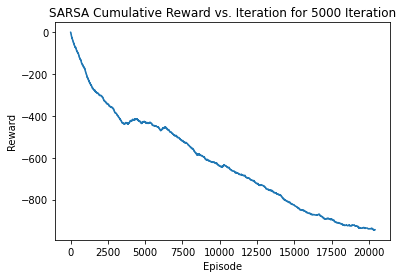

Games played: 6000
Games played: 7000
Games played: 8000
Games played: 9000
Games played: 10000


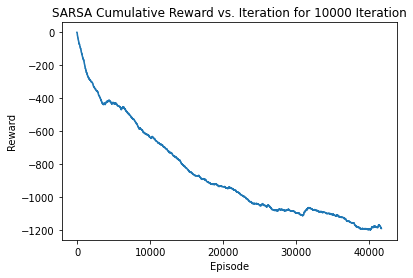

Games played: 11000
Games played: 12000
Games played: 13000
Games played: 14000
Games played: 15000


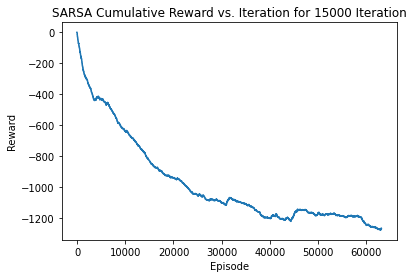

Games played: 16000
Games played: 17000
Games played: 18000
Games played: 19000
Games played: 20000


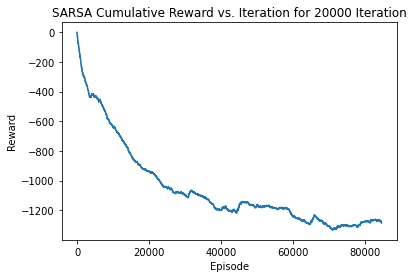

Games played: 21000
Games played: 22000
Games played: 23000
Games played: 24000
Games played: 25000


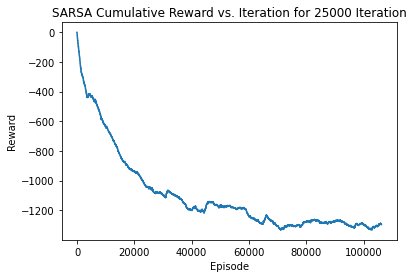

In [11]:
path = None
agent_type = "s"
if path is None:
    path = 'q.pkl' if agent_type == 'q' else 's.pkl'
sl = stateHolder(path, agent_type )

for i in range(5):
    sl.beginTeaching((i+1)*5000)
    with open("s.pkl", 'rb') as f:
        agent = pickle.load(f)
    plt.plot(np.cumsum(agent.rewards))
    plt.title('SARSA Cumulative Reward vs. Iteration for {} Iteration'.format((i+1)*5000))
    plt.ylabel('Reward')
    plt.xlabel('Episode')
    plt.show()

<h3><b>Results for Q-Learning

An agent is already saved at q.pkl.
Are you sure you want to overwrite? [y/n]: y
Games played: 1000


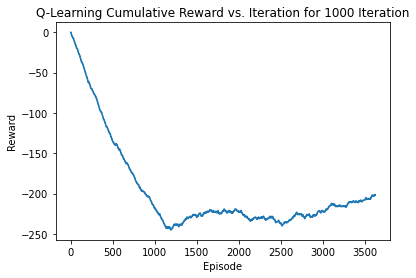

Games played: 2000


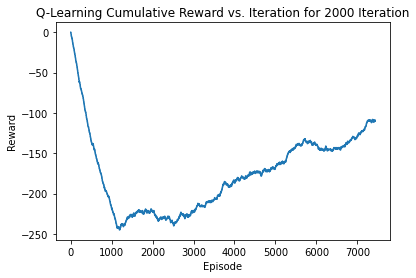

Games played: 3000


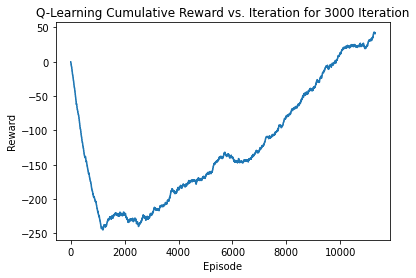

Games played: 4000


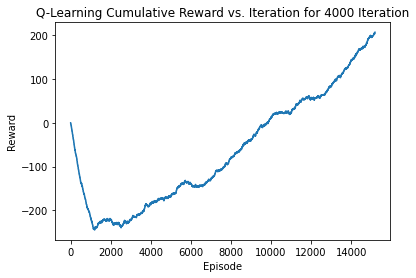

Games played: 5000


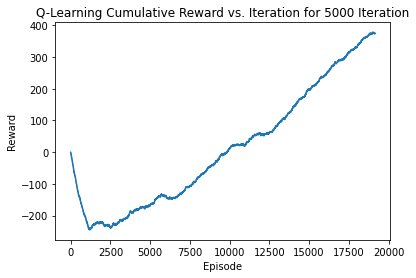

In [12]:
path = None
agent_type = "q"
if path is None:
    path = 'q.pkl' if agent_type == 'q' else 's.pkl'
sl = stateHolder(path, agent_type )

for i in range(5):
    sl.beginTeaching((i+1)*1000)
    with open("q.pkl", 'rb') as f:
        agent = pickle.load(f)
    plt.plot(np.cumsum(agent.rewards))
    plt.title('Q-Learning Cumulative Reward vs. Iteration for {} Iteration'.format((i+1)*1000))
    plt.ylabel('Reward')
    plt.xlabel('Episode')
    plt.show()